## Introduction

In this project, I aim to analyse beverage sales data for different kinds of customers and perform customer segmentation so we can best focus sales effort on most important products/customers/regions.

This dataset was created to simulate realistic sales patterns in the beverage industry. It features both Business-to-Business (B2B) and Business-to-Consumer (B2C) transactions, making it adaptable for a variety of analytical purposes.

Github link- https://github.com/arshit3005/CSCA-5632-Final-Project.git

Dataset link- https://www.kaggle.com/datasets/sebastianwillmann/beverage-sales

<b><i>Due to the large dataset file size, i was not able to upload it to github. you can download it from kaggle and then run the code.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [2]:
df=pd.read_csv('synthetic_beverage_sales_data.csv')

In [3]:
df.head()

,Order_ID,Customer_ID,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region,Order_Date
0,ORD1,CUS1496,B2B,Vio Wasser,Water,1.66,53,0.10,79.18,Baden-Württemberg,2023-08-23
1,ORD1,CUS1496,B2B,Evian,Water,1.56,90,0.10,126.36,Baden-Württemberg,2023-08-23
2,ORD1,CUS1496,B2B,Sprite,Soft Drinks,1.17,73,0.05,81.14,Baden-Württemberg,2023-08-23
3,ORD1,CUS1496,B2B,Rauch Multivitamin,Juices,3.22,59,0.10,170.98,Baden-Württemberg,2023-08-23
4,ORD1,CUS1496,B2B,Gerolsteiner,Water,0.87,35,0.10,27.40,Baden-Württemberg,2023-08-23


## EDA

In [4]:
round(df.describe(),3)

,Unit_Price,Quantity,Discount,Total_Price
count,8999910.000,8999910.000,8999910.000,8999910.000
mean,5.818,23.138,0.030,130.744
std,14.701,26.893,0.045,509.695
min,0.320,1.000,0.000,0.300
25%,1.050,6.000,0.000,8.400
50%,1.750,11.000,0.000,21.140
75%,3.210,30.000,0.050,69.490
max,169.530,100.000,0.150,14295.300


Now let's check how many unique values do we have in non-numeric columns

In [5]:
columns=[]
for cols in df.columns:
    if df[cols].dtype=='O':
        columns.append(cols)

df[columns].nunique()

Order_ID         3000000
Customer_ID        10000
Customer_Type          2
Product               47
Category               4
Region                16
Order_Date          1094
dtype: int64

In [6]:
df.isnull().any() | df.isna().any()

Order_ID         False
Customer_ID      False
Customer_Type    False
Product          False
Category         False
Unit_Price       False
Quantity         False
Discount         False
Total_Price      False
Region           False
Order_Date       False
dtype: bool

As we can see, the data does not have any missing values or non-numeric values so no need to drop any rows or fill any missing values.

<hr>

<Axes: title={'center': 'Customer Type'}, xlabel='Customer_Type'>

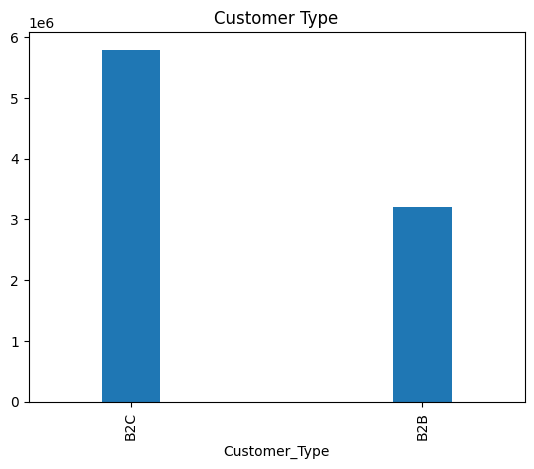

In [7]:
bar_width = 0.2
plt.title('Customer Type')
df['Customer_Type'].value_counts().plot.bar(width=bar_width)

In [8]:
sales_by_type=df.groupby('Customer_Type')['Total_Price'].sum().sort_values()

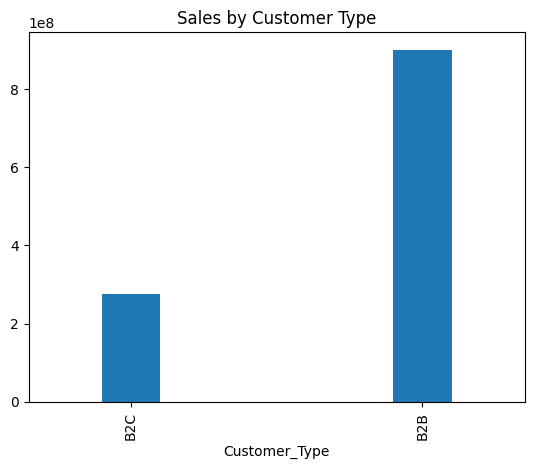

In [9]:
bar_width = 0.2
plt.title('Sales by Customer Type')
sales_by_type.plot.bar(width=bar_width)
plt.show()

From the above two charts, we can see that while the number of B2C customers are higher, the revenue generated by B2B customers is much higher so naturally, that's where we should be focusing more sales effort as businesses tend to give bigger orders than individual retail customers.

In [10]:
B2B_customers=df[df['Customer_Type']=='B2B']
customer_purchases=B2B_customers.groupby('Customer_ID')['Total_Price'].sum().sort_values()
customer_purchases

Customer_ID
CUS5510    154343.58
CUS9867    166886.17
CUS3322    167850.33
CUS685     169908.90
CUS454     169942.84
             ...    
CUS9241    353829.40
CUS8215    354744.41
CUS5120    356102.09
CUS2190    359547.51
CUS3866    367741.61
Name: Total_Price, Length: 3563, dtype: float64

In this sample output, we can see the top 5 B2B customers who have purchased the least and the most from the store.

In [11]:
bottom_5=customer_purchases[:5]
top_5=customer_purchases[-5:]
remaining_customer=customer_purchases[5:-5]

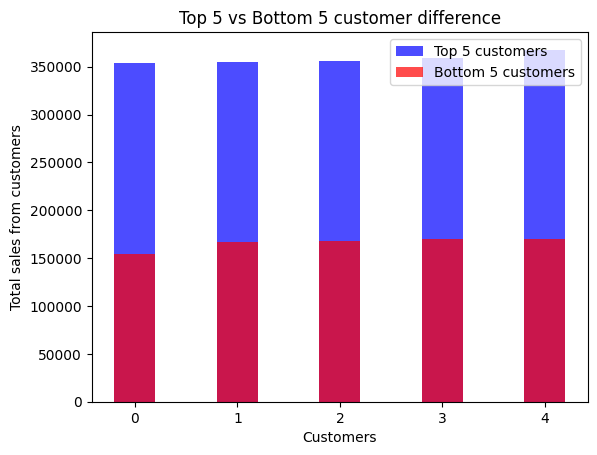

In [12]:
bar_width = 0.4
x = np.arange(len(top_5))
plt.bar(x, top_5.values, width=bar_width, color='blue', alpha=0.7, label='Top 5 customers')
plt.bar(x, bottom_5.values, width=bar_width, color='red', alpha=0.7, label='Bottom 5 customers')
plt.legend()
plt.xlabel("Customers")
plt.ylabel("Total sales from customers")
plt.title("Top 5 vs Bottom 5 customer difference")
plt.show()

We can see from the above chart, that the top 5 B2B customers generate almost twice as much revenue for the company than bottom 5 B2B so naturally the top 5 customer orders should always receive the top priority.

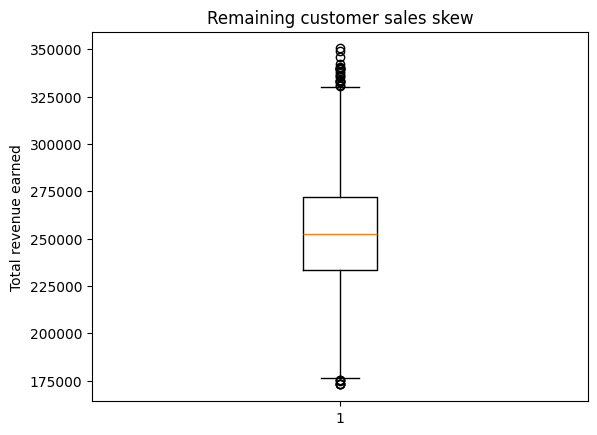

In [13]:
plt.title('Remaining customer sales skew')
plt.boxplot(remaining_customer.values)
plt.ylabel('Total revenue earned')
plt.show()

Next we examine total sales by region so we know where to deploy the sales force the most.

In [14]:
regional_sales=df.groupby('Region')['Total_Price'].sum().sort_values()

<Axes: title={'center': 'Total sales by region'}, xlabel='Region'>

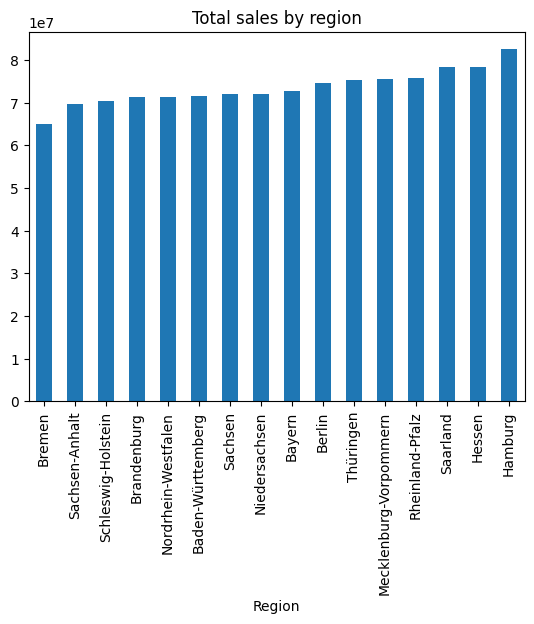

In [15]:
plt.title('Total sales by region')
regional_sales.plot.bar()

We can observe from the chart that Hamburg region generates the most revenue where Bremen generates the least revenue. However the difference between the two regions isn't that much hence all regions should be given high priority.

## Model preparation and analysis

Now we would like to try using K-means Clustering to see if we can find any discernable patterns between different clusters of customers.

In [16]:
dataset=B2B_customers.groupby('Customer_ID')['Total_Price'].sum().reset_index()
dataset['Total_quantity']=B2B_customers.groupby('Customer_ID')['Quantity'].sum().values
dataset['Total_discount']=B2B_customers.groupby('Customer_ID')['Discount'].sum().values

In [17]:
dataset.head()

,Customer_ID,Total_Price,Total_quantity,Total_discount
0,CUS1000,271186.90,44318,72.90
1,CUS10000,253436.72,46184,77.85
2,CUS1002,247201.91,42082,69.80
3,CUS1005,259063.08,44551,73.70
4,CUS1006,277493.87,47627,79.50


In [18]:
X=dataset[['Total_Price','Total_quantity','Total_discount']]

In [19]:
def normalization(data): #Gaussian normalization
    for column in data.columns:
        mean=np.mean(data[column])
        std=np.std(data[column])
        data[column]=(data[column]-mean)/std
    return data
    
X=normalization(X)
X.head()

C:\Users\arshit\AppData\Local\Temp\ipykernel_32704\2485325086.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column]=(data[column]-mean)/std


,Total_Price,Total_quantity,Total_discount
0,0.608823,-0.370524,-0.447027
1,0.012959,0.249130,0.561989
2,-0.196341,-1.113046,-1.078935
3,0.201833,-0.293150,-0.283954
4,0.820545,0.728316,0.898327


In [20]:
kmeans = KMeans(n_clusters=3, n_init="auto").fit(X)
labels=kmeans.labels_
dataset['cluster']=labels.tolist()

C:\Users\arshit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\arshit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^

In [21]:
dataset['cluster'].value_counts()

cluster
1    1658
0     996
2     909
Name: count, dtype: int64

In [22]:
dataset.head()

,Customer_ID,Total_Price,Total_quantity,Total_discount,cluster
0,CUS1000,271186.90,44318,72.90,1
1,CUS10000,253436.72,46184,77.85,1
2,CUS1002,247201.91,42082,69.80,0
3,CUS1005,259063.08,44551,73.70,1
4,CUS1006,277493.87,47627,79.50,2


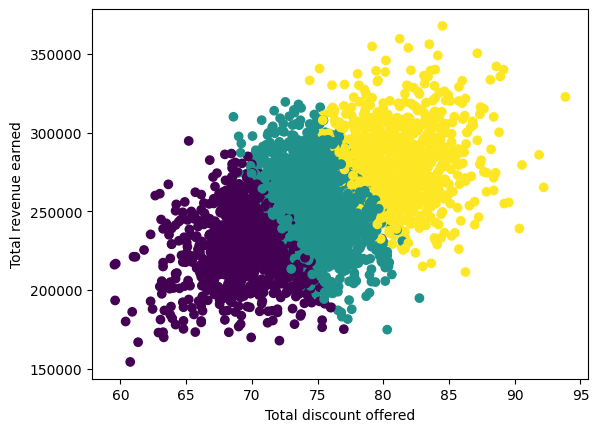

In [23]:
plt.scatter(dataset['Total_discount'],dataset['Total_Price'],c=dataset['cluster'])
plt.xlabel('Total discount offered')
plt.ylabel('Total revenue earned')
plt.show()

While there are no discernable patterns in our data, we can clearly see clients in the yellow cluster have been offered the most discount and have also generated the highest revenue. However clients in the purple cluster have been offered the lowest discount and have generated the lowest discount. While it's hard to tell if there's a direct causation between discount offered and sales generated per client, maybe the sales people can check with the clients in purple cluster if offering a higher discount can lead to higher sales.

## Conclusion

In this assignment, I aimed to analyse beverage sales data to analyse revenue earned based on customer type and region of sale. We discovered that while B2C customers constituted the majority of customers, revenue generated by B2B customers was several times higher hence as a beverage company, they should clearly be the priority. We also tried to apply K-means clustering to classify customers into different segments to see if we find any pattern. While no proper pattern was found, we did notice a slight correlation between discount offered and revenue generated and is something that should be explored further.